In [2]:
import numpy as np
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Subset
import tqdm
from importlib import reload
import matplotlib.pyplot as plt
from matplotlib import ticker

import utils.mm_mnist
from utils.noise import GMMNoise
import dgcca.dgcca
import dgcca.anomaly_detection

## Load datasets

In [3]:
ds_train = utils.mm_mnist.MM_MNIST('../data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

ds_test = utils.mm_mnist.MM_MNIST('../data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

split = [50000, 10000]

ds_train_cca = Subset(ds_train, range(0, split[0]))
ds_train_ad = Subset(ds_train, range(split[0], split[0] + split[1]))

In [4]:
batch_size=128
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True)
dl_train_cca = torch.utils.data.DataLoader(ds_train_cca, batch_size=batch_size, shuffle=True)
dl_train_ad = torch.utils.data.DataLoader(ds_train_ad, batch_size=len(ds_train_ad), shuffle=False) # No shuffle as corrupt and clean data must be loaded in the same order
dl_test_classifier = torch.utils.data.DataLoader(ds_test, batch_size=batch_size)
dl_test_ad = torch.utils.data.DataLoader(ds_test, batch_size=len(ds_test))

## Train or load MM-MNIST classifier

In [4]:
#MLP
classifier = utils.mm_mnist.MM_Classifier(4, (1,14,14), dropout=0.2, moddrop=0, head_type='mlp', activation=torch.tanh)
criterion = nn.CrossEntropyLoss()

In [202]:
#CNN
classifier = utils.mm_mnist.MM_Classifier(4, (1,14,14), dropout=0.2, moddrop=0.1, head_type='cnn')
criterion = nn.CrossEntropyLoss()

In [133]:
classifier.train()

epochs = 80
lr=1e-4
optimiser = torch.optim.Adam(classifier.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5, amsgrad=False)

losses = []
with tqdm.auto.tqdm(total=epochs) as pbar:
    for epoch in range(epochs):
        total_loss = 0
        for batch, (data, label) in enumerate(dl_train):
            optimiser.zero_grad()
            out = classifier(data)
            loss = criterion(out, label)
            total_loss += loss
            total_loss_avg = total_loss / ((batch + 1))
            loss.backward()
            optimiser.step()
            pbar.set_description('Epoch: {:3}/{} | Error: {:.4f}'.format(epoch+1, epochs, total_loss_avg))
        pbar.update(1)
        losses.append(total_loss/len(dl_train))


Epoch:  80/80 | Error: 0.0464: 100%|██████████| 80/80 [2:11:12<00:00, 98.40s/it] 


In [134]:
#torch.save(classifier.state_dict(), 'output/mm_mnist_cnn_moddrop.pth')

In [258]:
classifier = utils.mm_mnist.MM_Classifier(4, (1,14,14), dropout=0.2, moddrop=0.1, head_type='cnn')
classifier.load_state_dict(torch.load('output/mm_mnist_cnn_moddrop.pth'))

<All keys matched successfully>

In [18]:
def eval_classifier(loader=dl_test_classifier):
    classifier.eval()

    correct = 0
    with tqdm.auto.tqdm(total=len(loader)) as pbar:
        total_loss = 0
        for batch, (data, label) in enumerate(loader):
            out = classifier(data).detach()
            loss = criterion(out, label)
            total_loss += loss
            total_loss_avg = total_loss / ((batch + 1))
            pred = np.argmax(out, axis=1)
            correct += np.sum((pred==label).numpy().astype(int))
            pbar.update(1)
            pbar.set_description('Accuracy: {:.2%} | Error: {:.4f}'.format(correct/((batch+1)*batch_size), total_loss_avg))
    acc = correct/len(ds_test)

In [135]:
eval_classifier(dl_train)

Accuracy: 99.72% | Error: 0.0080: 100%|██████████| 469/469 [02:06<00:00,  3.71it/s]


In [259]:
eval_classifier(dl_test_classifier)

Accuracy: 97.77% | Error: 0.0324: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


## Train DGCCA 

In [260]:
def embed(loader=dl_train_cca, noise=None):
    classifier.eval()

    with tqdm.auto.tqdm(total=len(loader)) as pbar:
        pbar.set_description('Embedding')
        out = []
        for batch, (data, _) in enumerate(loader):
            data = data if noise is None else noise(data)
            out.append([mod.detach() for mod in classifier(data, heads=True)])
            pbar.update(1)
    output = []
    for i in range(4):
        output.append(np.concatenate([batch[i] for batch in out]))
    return output

In [261]:
train_cca_embeddings = [torch.as_tensor(mod, dtype=torch.double) for mod in embed(dl_train_cca)] # Get pre-fusion representation for each modality

Embedding: 100%|██████████| 391/391 [01:13<00:00,  5.31it/s]


In [262]:
cca = dgcca.dgcca.DGCCA([[512, 125, 64]]*4, 32, device='cpu', use_all_singular_values=False)

In [140]:
cca.train(train_cca_embeddings, epochs=60, batch_size=128, cca_dim=20, cca_hidden_dim=1000)

Embedding training set:: 100%|██████████| 391/391 [00:13<00:00, 28.76it/s]
Decomposed data matrix for view 0
Decomposed data matrix for view 1
Decomposed data matrix for view 2
Decomposed data matrix for view 3
Decomposed M_tilde / solved for G
Solved for U in view 0
Solved for U in view 1
Solved for U in view 2
Solved for U in view 3


In [141]:
#cca.save_checkpoint('output/mm_mnist_cca_cnn_moddrop.pth')

In [396]:
cca.load_checkpoint('output/mm_mnist_cca_cnn_moddrop.pth')
cca.train(train_cca_embeddings, epochs=1, batch_size=128, cca_dim=15, cca_hidden_dim=1000)

Embedding training set:: 100%|██████████| 391/391 [00:11<00:00, 32.92it/s]
Decomposed data matrix for view 0
Decomposed data matrix for view 1
Decomposed data matrix for view 2
Decomposed data matrix for view 3
Decomposed M_tilde / solved for G
Solved for U in view 0
Solved for U in view 1
Solved for U in view 2
Solved for U in view 3


## Embed clean and corrupted data

In [399]:
snr = 0

clean = [torch.as_tensor(mod, dtype=torch.double) for mod in embed(dl_train_ad)]

if not 'noise_gen' in locals():
    noise_gen = utils.noise.GMMNoise(dl_train_ad, 9) # Train GMM for each pixel to generate noise

noise = lambda data: noise_gen.add_noise(data, snr=snr) # noise and image weighted equally
corrupt = [torch.as_tensor(mod, dtype=torch.double) for mod in embed(dl_train_ad, noise)]

Embedding: 100%|██████████| 1/1 [00:15<00:00, 15.15s/it]


In [304]:
clean_embed = cca.get_all_embeddings(clean)
corrupt_embed = cca.get_all_embeddings(corrupt)

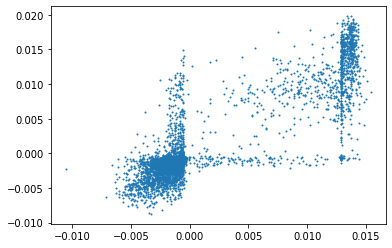

In [305]:
plt.scatter(clean_embed[0][:,0], clean_embed[1][:,0], s=1)
plt.show()

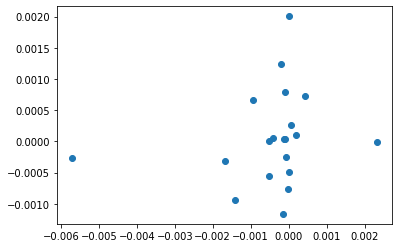

In [270]:
plt.scatter(clean_embed[0][0], corrupt_embed[1][0])
plt.show()

## Correlation between CCA dimensions for a single sample

In [306]:
def avgcorr(num, ds1, ds2):
    sums = []
    for i in range(num):
        for j in range(4):
            for k in range(4):
                sums.append(np.corrcoef(ds1[j][i], ds2[k][i])[0,1])
    return sums

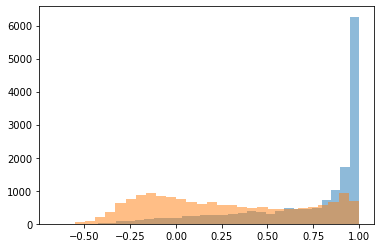

In [307]:
clean_corr = avgcorr(1000, clean_embed, clean_embed)
corrupt_corr = avgcorr(1000, clean_embed, corrupt_embed)
plt.hist(clean_corr, bins=30, alpha=0.5)
plt.hist(corrupt_corr, bins=30, alpha=0.5)
plt.show()

In [308]:
def show(image):
    full_image = np.zeros((28,28))
    full_image[0:14,0:14] = image[0]
    full_image[0:14,14:] = image[1]
    full_image[14:,0:14] = image[2]
    full_image[14:,14:] = image[3]
    plt.imshow(full_image, cmap='gray')

In [309]:
for data, label in dl_test_ad:
    samples = data

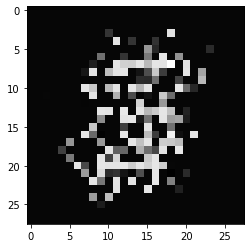

In [328]:
show_noise = lambda data, modality: noise_gen.add_noise(data, snr=0, modality=modality) # noise and image weighted equally
show(show_noise([mod[4,:,:] for mod in samples], modality=[0,1,2,3]))

## Train anomaly detector

In [329]:
window_size = 30

In [401]:
reload(dgcca.anomaly_detection)

<module 'dgcca.anomaly_detection' from 'c:\\Users\\harry\\Documents\\Work\\Dissertation\\robust-mm\\dgcca\\anomaly_detection.py'>

Getting data embeddings...
[0, 0, 0, 0]
Getting noise embeddings...
[0, 0, 0, 0]
Computing (0,1) threshold:   0%|          | 0/6.0 [00:00<?, ?it/s]C:\Users\harry\miniconda3\envs\diss\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\harry\miniconda3\envs\diss\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
Computing (0,1) threshold:  17%|█▋        | 1/6.0 [00:02<00:10,  2.20s/it]----
0.48001732435508276
nan
0.09875357868786305
nan
Computing (0,2) threshold:  17%|█▋        | 1/6.0 [00:02<00:10,  2.20s/it]----
0.4838400325500217
0.00029587203589128786
0.0966042122729617
0.052193960323482086
Computing (0,3) threshold:  50%|█████     | 3/6.0 [00:06<00:06,  2.24s/it]----
0.42092357497319727
1.9520911348043027e-05
0.10094737798323085
0.05383112646758937
Computing (1,2) threshold:  50%|█████     | 3/6.0 [00:06<00:06,  2.24

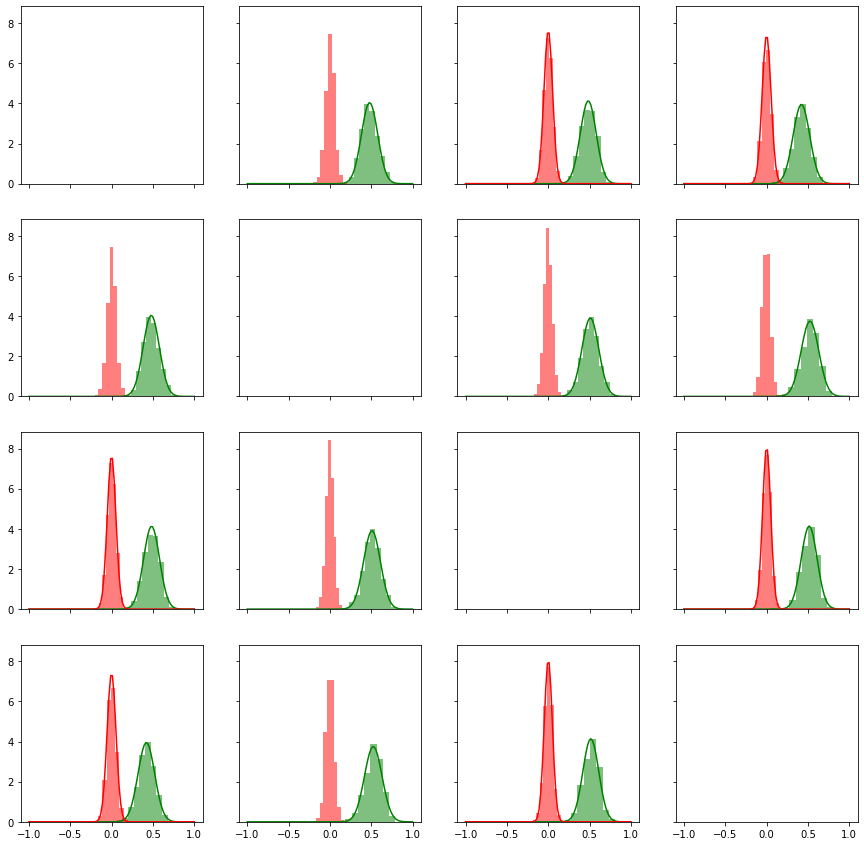

In [402]:
detector = dgcca.anomaly_detection.CcaAnomalyDetector(cca)

fig = detector.train(clean, corrupt, stride='auto', window=window_size, plot=True)

In [331]:
detector.type_1

array([[0.        , 0.12295191, 0.10277392, 0.19336084],
       [0.        , 0.        , 0.09934799, 0.10645503],
       [0.        , 0.        , 0.        , 0.1049788 ],
       [0.        , 0.        , 0.        , 0.        ]])

In [279]:
detector.type_2

array([[0.        , 0.04226919, 0.03074448, 0.08963068],
       [0.        , 0.        , 0.02892956, 0.03828196],
       [0.        , 0.        , 0.        , 0.0417832 ],
       [0.        , 0.        , 0.        , 0.        ]])

In [333]:
def eval(data, detector, noise, num_corrupt=0, window=20, grace=0):
    classifier.eval()
    tp_pred, tn_pred, fp_pred, fn_pred, tp_ind, tn_ind, fp_ind, fn_ind = (0,0,0,0,0,0,0,0)
    with tqdm.auto.tqdm(total=len(range(0, len(data[0])-window, window))) as pbar:
        for i in range(0, len(data[0])-window, window):
            clean = np.ones(len(data))
            corrupt = np.random.default_rng().choice(len(data), size=num_corrupt, replace=False)
            clean[corrupt] = 0
            corrupt_data = noise([mod[i:i+window,:].numpy() for mod in data], corrupt)
            corrupt_data = [torch.FloatTensor(mod) for mod in corrupt_data]

            embedding = classifier(corrupt_data, heads=True)

            pred, individual = detector.detect_anomalies([mod.double() for mod in embedding], grace=grace, evaluating=True)

            for j in range(0,4):
                for k in range(j+1,4):
                    if j in corrupt or k in corrupt:
                        if not individual[j,k]:
                            tn_ind += 1
                        else:
                            fp_ind += 1
                    else:
                        if individual[j,k]:
                            tp_ind += 1
                        else:
                            fn_ind += 1
                        
            tp_pred += ((clean == pred) & (pred == True)).sum()
            tn_pred += ((clean == pred) & (pred == False)).sum()
            fp_pred += ((clean != pred) & (pred == True)).sum()
            fn_pred += ((clean != pred) & (pred == False)).sum()

            pbar.update(1)
            pbar.set_description('Prediction accuracy: {:.2%} | Individual accuracy: {:.2%} '.format((tp_pred+tn_pred)/(4*(1+(i/window))), (tp_ind+tn_ind)/(6*(1+(i/window)))))
    return np.array([[tp_pred, tn_pred, fp_pred, fn_pred],
                     [tp_ind, tn_ind, fp_ind, fn_ind]])

test_noise = lambda data, modality: noise_gen.add_noise(data, snr=snr, modality=modality)

In [341]:
def eval_both(classifier, data, labels, detector, noise, num_corrupt=0, window=20, grace=0):
    classifier.eval()
    tp_pred, tn_pred, fp_pred, fn_pred, tp_ind, tn_ind, fp_ind, fn_ind = (0,0,0,0,0,0,0,0)
    correct_raw = 0
    correct_cleaned = 0
    with tqdm.auto.tqdm(total=len(range(0, len(data[0])-window, window))) as pbar:
        for i in range(0, len(data[0])-window, window):
            clean = np.ones(len(data))
            corrupt = np.random.default_rng().choice(len(data), size=num_corrupt, replace=False)
            clean[corrupt] = 0
            corrupt_data = noise([mod[i:i+window,:].numpy() for mod in data], corrupt)
            corrupt_data = [torch.FloatTensor(mod) for mod in corrupt_data]

            embedding = classifier(corrupt_data, heads=True)

            pred, individual = detector.detect_anomalies([mod.double() for mod in embedding], grace=grace, evaluating=True)

            for j in range(0,4):
                for k in range(j+1,4):
                    if j in corrupt or k in corrupt:
                        if not individual[j,k]:
                            tn_ind += 1
                        else:
                            fp_ind += 1
                    else:
                        if individual[j,k]:
                            tp_ind += 1
                        else:
                            fn_ind += 1
                        
            tp_pred += ((clean == pred) & (pred == True)).sum()
            tn_pred += ((clean == pred) & (pred == False)).sum()
            fp_pred += ((clean != pred) & (pred == True)).sum()
            fn_pred += ((clean != pred) & (pred == False)).sum()

            # Accuracy for raw data
            raw_pred = classifier(embedding, tails=True).detach()
            for sample in range(embedding[0].shape[0]):
                if np.argmax(raw_pred[sample]) == labels[i+sample]:
                    correct_raw += 1

            # Accuracy for cleaned data
            cleaned_data = embedding
            for mod in range(len(pred)):
                if pred[mod] == False:
                    cleaned_data[mod] = torch.zeros_like(cleaned_data[mod])

            cleaned_pred = classifier(cleaned_data, tails=True).detach()
            for sample in range(embedding[0].shape[0]):
                if np.argmax(cleaned_pred[sample]) == labels[i+sample]:
                    correct_cleaned += 1


            pbar.update(1)
            pbar.set_description('{} corrupt: Prediction accuracy: {:.2%} | Individual accuracy: {:.2%} | Raw accuracy: {:.2%} | Cleaned accuracy: {:.2%}'.format(num_corrupt, (tp_pred+tn_pred)/(4*(1+(i/window))), (tp_ind+tn_ind)/(6*(1+(i/window))), correct_raw/(i+window), correct_cleaned/(i+window)))
    return (np.array([[tp_pred, tn_pred, fp_pred, fn_pred],
                     [tp_ind, tn_ind, fp_ind, fn_ind]]), correct_raw/(i+window), correct_cleaned/(i+window))

test_noise = lambda data, modality: utils.noise.add_gaussian_noise(data, snr=snr, modality=modality)
#test_noise = lambda data, modality: noise_gen.add_noise(data, snr=snr, modality=modality)

In [334]:
for data, label in dl_test_ad:
    #data = [mod.numpy() for mod in data]
    eval_both(data, label, detector, test_noise, 0, window_size, 0)

Prediction accuracy: 81.01% | Individual accuracy: 87.01% | Raw accuracy: 98.87% | Cleaned accuracy: 96.26%: 100%|██████████| 499/499 [00:33<00:00, 15.01it/s]


In [178]:
for data, label in dl_test_ad:
    #data = [mod.numpy() for mod in data]
    eval_both(data, label, detector, test_noise, 0, window_size, 1)

Prediction accuracy: 99.37% | Individual accuracy: 97.24% | Raw accuracy: 98.86% | Cleaned accuracy: 98.85%: 100%|██████████| 199/199 [00:19<00:00, 10.44it/s]


In [187]:
for data, label in dl_test_ad:
    #data = [mod.numpy() for mod in data]
    eval_both(data, label, detector, test_noise, 1, window_size, 0)

Prediction accuracy: 99.50% | Individual accuracy: 97.49% | Raw accuracy: 98.04% | Cleaned accuracy: 97.36%: 100%|██████████| 199/199 [00:21<00:00,  9.42it/s]


In [188]:
for data, label in dl_test_ad:
    #data = [mod.numpy() for mod in data]
    eval_both(data, label, detector, test_noise, 1, window_size, 1)

Prediction accuracy: 99.62% | Individual accuracy: 97.65% | Raw accuracy: 97.84% | Cleaned accuracy: 97.35%: 100%|██████████| 199/199 [00:19<00:00, 10.11it/s]


In [189]:
for data, label in dl_test_ad:
    #data = [mod.numpy() for mod in data]
    eval_both(data, label, detector, test_noise, 2, window_size, 0)

Prediction accuracy: 95.60% | Individual accuracy: 97.57% | Raw accuracy: 93.86% | Cleaned accuracy: 91.10%: 100%|██████████| 199/199 [00:20<00:00,  9.69it/s]


In [190]:
for data, label in dl_test_ad:
    #data = [mod.numpy() for mod in data]
    eval_both(data, label, detector, test_noise, 2, window_size, 1)

Prediction accuracy: 96.86% | Individual accuracy: 98.32% | Raw accuracy: 93.99% | Cleaned accuracy: 91.02%: 100%|██████████| 199/199 [00:19<00:00, 10.24it/s]


In [54]:
noise_gen = utils.noise.GMMNoise(dl_train_ad, 5)

Generating GMM for dataset: 100%|██████████| 4/4 [00:59<00:00, 14.79s/it]


In [392]:
reload(dgcca.anomaly_detection)

<module 'dgcca.anomaly_detection' from 'c:\\Users\\harry\\Documents\\Work\\Dissertation\\robust-mm\\dgcca\\anomaly_detection.py'>

In [393]:
def pipeline(classifier, cca_dim, snr, gmm_components, window_size, grace, cca_path, noise_gen=None):
    classifier.eval()
    cca = dgcca.dgcca.DGCCA([[512, 125, 64]]*4, 32, device='cpu', use_all_singular_values=False)
    cca.load_checkpoint(cca_path)
    train_cca_embeddings = [torch.DoubleTensor(mod) for mod in embed(dl_train_cca)]
    cca.train(train_cca_embeddings, epochs=50, batch_size=128, cca_dim=cca_dim, cca_hidden_dim=1000)

    clean = [torch.DoubleTensor(mod) for mod in embed(dl_train_ad)]

    if noise_gen is None:
        noise_gen = utils.noise.GMMNoise(dl_train_ad, gmm_components) # Train GMM for each pixel to generate noise

    noise = lambda data: noise_gen.add_noise([mod.numpy() for mod in data], snr=snr) # noise and image weighted equally
    corrupt = [torch.DoubleTensor(mod) for mod in embed(dl_train_ad, noise)]
    print([torch.sum(torch.isnan(mod)) for mod in clean])
    print([torch.sum(torch.isnan(mod)) for mod in corrupt])

    detector = dgcca.anomaly_detection.CcaAnomalyDetector(cca)
    detector.train(clean, corrupt, stride='auto', window=window_size)

    test_noise = lambda data, modality: noise_gen.add_noise(data, snr=snr, modality=modality)

    results = {}
    for data, label in dl_test_ad:
        data = [mod.double() for mod in data]
        for num_corrupt in [0,1,2]:
            results[num_corrupt] = {}
            results[num_corrupt]['ad'], results[num_corrupt]['raw'], results[num_corrupt]['clean'] = eval_both(classifier, data, label, detector, test_noise, num_corrupt, window_size, grace)
    
    return results

In [394]:
res = pipeline(classifier, cca_dim=15, snr=0, gmm_components=7, window_size=30, grace=0, cca_path='output/mm_mnist_cca_cnn_moddrop.pth', noise_gen=noise_gen)

Embedding training set:: 100%|██████████| 391/391 [00:12<00:00, 32.14it/s]
Decomposed data matrix for view 0
Decomposed data matrix for view 1
Decomposed data matrix for view 2
Decomposed data matrix for view 3
Decomposed M_tilde / solved for G
Solved for U in view 0
Solved for U in view 1
Solved for U in view 2
Embedding: 100%|██████████| 1/1 [00:14<00:00, 14.50s/it]
[tensor(0), tensor(0), tensor(0), tensor(0)]
[tensor(0), tensor(0), tensor(0), tensor(0)]
Getting data embeddings...
[0, 0, 0, 0]
Getting noise embeddings...
Computing (0,1) threshold:   0%|          | 0/6.0 [00:00<?, ?it/s][0, 0, 0, 0]
C:\Users\harry\miniconda3\envs\diss\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\harry\miniconda3\envs\diss\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
Computing (0,2) threshold:  17%|█▋        | 1/6.0 [00:02<0

In [349]:
import pickle

In [356]:
with open('output/pkltst.pkl', 'wb') as f:
    pickle.dump(res,f)

In [357]:
with open('output/pkltst.pkl', 'rb') as f:
    res2 = pickle.load(f)

{'ad': array([[ 673,    0,    0,  123],
        [1067,    0,    0,  127]]),
 'raw': 0.9886432160804021,
 'clean': 0.9689447236180905}

In [60]:
classifier = utils.mm_mnist.MM_Classifier(4, (1,14,14), dropout=0.2, moddrop=0, activation=torch.tanh)
classifier.load_state_dict(torch.load('output/mm_mnist.pth'))

results = []
for dims in [5,10,20,40,60]:
    dim_results = []
    for window_size in [5,10,20,50,100]:
        print('======= dims: {} | window_size: {} ======='.format(dims, window_size))
        dim_results.append(pipeline(classifier, cca_dim=dims, snr=1, gmm_components=5, window_size=window_size, grace=0, noise_gen=noise_gen))
    results.append(dim_results)

00:04<00:00,  4.39s/it]
Getting data embeddings...
Getting noise embeddings...
Computing (2,3) threshold: 100%|██████████| 6/6.0 [00:08<00:00,  1.47s/it]
Prediction accuracy: 70.84% | Individual accuracy: 61.49% : 100%|██████████| 499/499 [03:19<00:00,  2.50it/s]
Embedding training set:: 100%|██████████| 391/391 [00:01<00:00, 282.45it/s]
Decomposed data matrix for view 0
Decomposed data matrix for view 1
Decomposed data matrix for view 2
Decomposed data matrix for view 3
Decomposed M_tilde / solved for G
Solved for U in view 0
Solved for U in view 1
Embedding:   0%|          | 0/1 [00:00<?, ?it/s]Solved for U in view 2
Solved for U in view 3
Embedding: 100%|██████████| 1/1 [00:05<00:00,  5.50s/it]
  0%|          | 0/6.0 [00:00<?, ?it/s]Getting data embeddings...
Getting noise embeddings...
Computing (2,3) threshold: 100%|██████████| 6/6.0 [00:12<00:00,  2.02s/it]
Prediction accuracy: 79.90% | Individual accuracy: 70.35% : 100%|██████████| 199/199 [01:24<00:00,  2.36it/s]
Embedding trai

In [487]:
for batch_size in [128]:
    for snr in [1.0]:
        for gmm_components in [5]:
            dims = []
            for window_size in [3,5,10,15,20,30,50,100,500]:
                windows = []
                for cca_dim in [5,10,15,20,30,50]:
                    for grace in [0]:
                        with open('output/{}_{}_{}_{}_{}_{}.npy'.format(batch_size, snr, gmm_components, cca_dim, window_size, grace), 'rb') as f:
                            windows.append(np.load(f))
                dims.append(np.stack(windows))


In [488]:
results = dims

In [489]:
def acc(raw, dim, corr, lines):
    res = []
    for i in range(len(lines)):
        res.append((raw[i][corr,dim,0]+raw[i][corr,dim,1])/np.sum(raw[i][corr,dim,:]))
    return res

In [490]:
def acc_window(res, window_idx, dim, corr, xs):
    data = [window[window_idx] for window in res]
    results = []
    for i in range(len(xs)):
        results.append((data[i][corr,dim,0]+data[i][corr,dim,1])/np.sum(data[i][corr,dim,:]))
    return results

In [8]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(18, 5))
for ax_idx in range(3):
    dims = [5,10,15,20,30,50]
    for dim in range(len(dims)):
        ax[ax_idx].plot(range(len([3,5,10,15,20,30,50,100,500])), acc(results[dim], 0, ax_idx, [5,10,15,20,30,50]))
    ax[ax_idx].legend([5,10,15,20,30,50])
    ax[ax_idx].set_xticklabels([0,3,5,10,15,20,30,50,100,500])
    ax[ax_idx].set_xlabel('Number of samples')
    ax[ax_idx].set_ylabel('Accuracy')
#fig.title('Overall modality corruption detection accuracy over varying CCA dimension')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (9,) and (6,)

<ipython-input-179-e1e8d7259f9f>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[ax_idx].set_xticklabels([0,5,10,15,20,30,50])


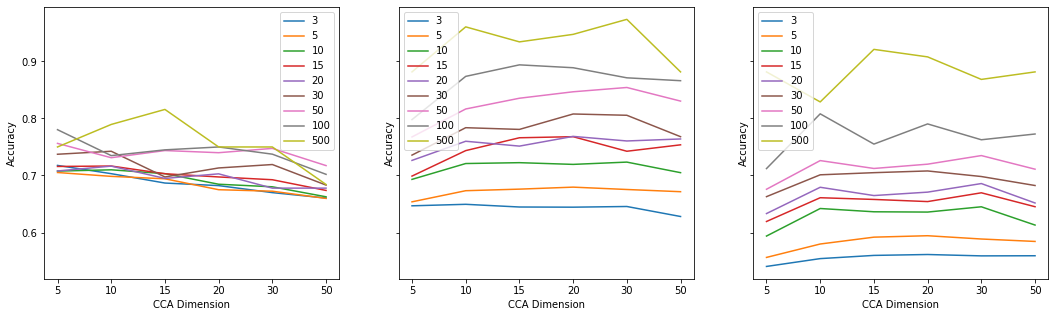

In [179]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(18, 5))
for ax_idx in range(3):
    windows = [3,5,10,15,20,30,50,100,500]
    for window in range(len(windows)):
        ax[ax_idx].plot(range(len([5,10,15,20,30,50])), acc_window(results, window, 0, ax_idx))
    ax[ax_idx].legend(windows)
    ax[ax_idx].set_xticklabels([0,5,10,15,20,30,50])
    ax[ax_idx].set_xlabel('CCA Dimension')
    ax[ax_idx].set_ylabel('Accuracy')
    #ax.set_title('Overall modality corruption detection accuracy over varying CCA dimension')
plt.show()

In [491]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(18, 5))
for ax_idx in range(3):
    dims = [5,10,15,20,30,50]
    for dim in range(len(dims)):
        ax[ax_idx].plot(range(len([3,5,10,15,20,30,50,100,500])), acc(results[dim], 1, ax_idx))
    ax[ax_idx].legend([5,10,15,20,30,50])
    ax[ax_idx].set_xticklabels([0,3,5,10,15,20,30,50,100,500])
    ax[ax_idx].set_xlabel('Number of samples')
    ax[ax_idx].set_ylabel('Accuracy')
#fig.title('Overall modality corruption detection accuracy over varying CCA dimension')
plt.show()

TypeError: acc() missing 1 required positional argument: 'lines'

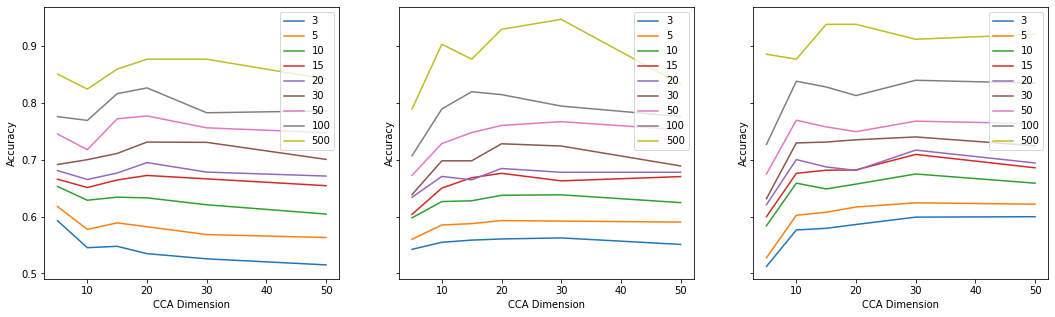

In [176]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(18, 5))
for ax_idx in range(3):
    windows = [3,5,10,15,20,30,50,100,500]
    for window in range(len(windows)):
        ax[ax_idx].plot([5,10,15,20,30,50], acc_window(results, window, 1, ax_idx))
    ax[ax_idx].legend(windows)
    ax[ax_idx].set_xlabel('CCA Dimension')
    ax[ax_idx].set_ylabel('Accuracy')
    #ax.set_title('Overall modality corruption detection accuracy over varying CCA dimension')
plt.show()

In [ ]:
first_window = [3,5,10,15,20,30,50,100,500]
first_dim = [5,10,15,20,30,50]

In [26]:
for batch_size in [128]:
    noise = []
    for snr in [0.0,0.25,0.5,0.75,1.0,2.0]:
        gmm = []
        for gmm_components in [1,3,5,7,9]:
            for cca_dim in [15]:
                for window_size in [30]:
                    for grace in [0]:
                        with open('output/{}_{}_{}_{}_{}_{}.npy'.format(batch_size, snr, gmm_components, cca_dim, window_size, grace), 'rb') as f:
                            gmm.append(np.load(f))
        noise.append(np.stack(gmm))
results = noise

In [190]:
len(results)

6

<ipython-input-14-823d9af2c993>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[ax_idx].set_xticklabels([0,1,' ',3,' ',5,' ',7,' ',9])


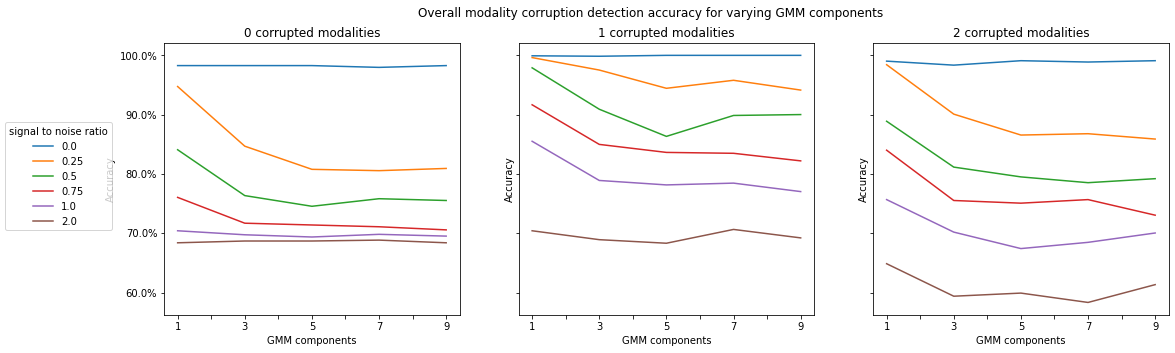

In [14]:
lines = [0.0,0.25,0.5,0.75,1.0,2.0]
xs = [1,3,5,7,9]

fig, ax = plt.subplots(1,3, sharey=True, figsize=(18, 5))
for ax_idx in range(3):
    for snr in range(len(lines)):
        ax[ax_idx].plot(xs, [100*el for el in acc(results[snr], 0, ax_idx, xs)])
    ax[ax_idx].yaxis.set_major_formatter(ticker.PercentFormatter())
    ax[ax_idx].set_xlabel('GMM components')
    ax[ax_idx].set_ylabel('Accuracy')
    ax[ax_idx].set_xticklabels([0,1,' ',3,' ',5,' ',7,' ',9])
    ax[ax_idx].set_title('{} corrupted modalities'.format(ax_idx))

fig.legend(lines, title='signal to noise ratio', loc='center left')
fig.suptitle('Overall modality corruption detection accuracy for varying GMM components')
plt.show()

In [29]:
def plots(results, lines, xs, xlabel, ylabel, legend, title):
    fig, ax = plt.subplots(1,3, sharey=True, figsize=(18, 5))
    for ax_idx in range(3):
        for line in range(len(lines)):
            ax[ax_idx].plot(xs, [100*el for el in acc(results[line], 0, ax_idx, xs)])
        ax[ax_idx].yaxis.set_major_formatter(ticker.PercentFormatter())
        ax[ax_idx].set_xlabel(xlabel)
        ax[ax_idx].set_ylabel(ylabel)
        ax[ax_idx].set_xticklabels([0,1,' ',3,' ',5,' ',7,' ',9])
        ax[ax_idx].set_title('{} corrupted modalities'.format(ax_idx))

    fig.legend(lines, title=legend, loc='center left')
    fig.suptitle(title)
    plt.show()

<ipython-input-29-6067c4b9164a>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[ax_idx].set_xticklabels([0,1,' ',3,' ',5,' ',7,' ',9])


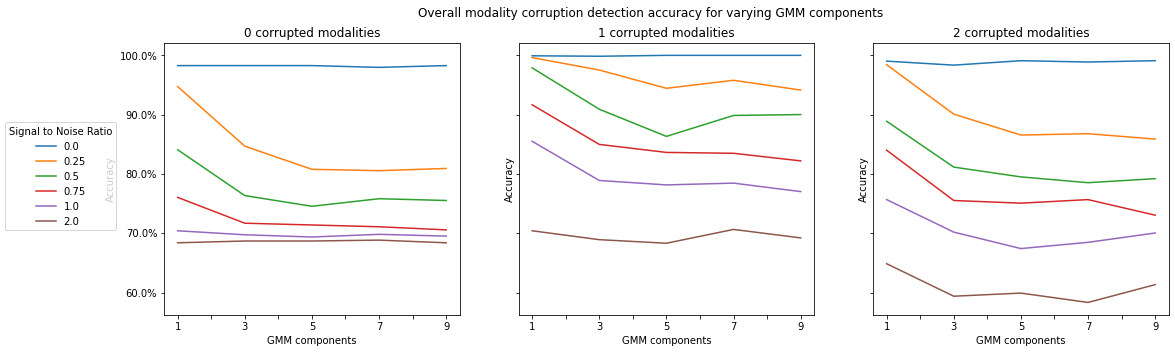

In [30]:
plots(results, [0.0,0.25,0.5,0.75,1.0,2.0], [1,3,5,7,9], 'GMM components', 'Accuracy', 'Signal to Noise Ratio', 'Overall modality corruption detection accuracy for varying GMM components')

In [9]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(18, 5))
for ax_idx in range(3):
    windows = [3,5,10,15,20,30,50,100,500]
    for window in range(len(windows)):
        ax[ax_idx].plot(range(len([5,10,15,20,30,50])), acc_window(results, window, 0, ax_idx))
    ax[ax_idx].legend(windows)
    ax[ax_idx].set_xticklabels([0,5,10,15,20,30,50])
    ax[ax_idx].set_xlabel('CCA Dimension')
    ax[ax_idx].set_ylabel('Accuracy')
ax[1].set_title('Overall modality corruption detection accuracy over varying CCA dimension')
plt.show()

TypeError: acc_window() missing 1 required positional argument: 'xs'

In [362]:
def get_acc(results):
    return (results[0]+results[1])/np.sum(results)

In [464]:
acc = []
raw_acc = []
clean_acc = []
for batch_size in [128]:
    for x, snr in enumerate([0.0,0.25,0.5,0.75,1.0,2.0]):
        acc.append([])
        raw_acc.append([])
        clean_acc.append([])
        for gmm_components in [1,3,5,7,9]:
            for cca_dim in [15]:
                for window_size in [30]:
                    for grace in [0]:
                        try:
                            with open('output/cnn_moddrop_{}_{}_{}_{}_{}_{}.pkl'.format(batch_size, snr, gmm_components, cca_dim, window_size, grace), 'rb') as f:
                                res = pickle.load(f)
                            acc[x].append([get_acc(res[ncorr]['ad'][0,:]) for ncorr in [0,1,2]])
                            raw_acc[x].append([res[ncorr]['raw'] for ncorr in [0,1,2]])
                            clean_acc[x].append([res[ncorr]['clean'] for ncorr in [0,1,2]])
                        except FileNotFoundError:
                            print('cant find {}_{}_{}_{}_{}_{}.pkl'.format(batch_size, snr, gmm_components, cca_dim, window_size, grace))
                            acc[x].append([0 for ncorr in [0,1,2]])
                            raw_acc[x].append([0 for ncorr in [0,1,2]])
                            clean_acc[x].append([0 for ncorr in [0,1,2]])

In [465]:
acc

[[[0.9984984984984985, 1.0, 0.963963963963964],
  [0.9984984984984985, 1.0, 0.8213213213213213],
  [0.9864864864864865, 1.0, 0.722972972972973],
  [0.9864864864864865, 1.0, 0.8798798798798799],
  [0.9864864864864865, 1.0, 0.8168168168168168]],
 [[0.9707207207207207, 0.9984984984984985, 0.9804804804804805],
  [0.9459459459459459, 0.9992492492492493, 0.9414414414414415],
  [0.9429429429429429, 0.9962462462462462, 0.8738738738738738],
  [0.9309309309309309, 0.9977477477477478, 0.8993993993993994],
  [0.93993993993994, 1.0, 0.8663663663663663]],
 [[0.9091591591591591, 0.9827327327327328, 0.9279279279279279],
  [0.8963963963963963, 0.9887387387387387, 0.9429429429429429],
  [0.8881381381381381, 0.9902402402402403, 0.9361861861861862],
  [0.8911411411411412, 0.9917417417417418, 0.9294294294294294],
  [0.8836336336336337, 0.9902402402402403, 0.9376876876876877]],
 [[0.8633633633633634, 0.9669669669669669, 0.8753753753753754],
  [0.8536036036036037, 0.9737237237237237, 0.9204204204204204],
  [

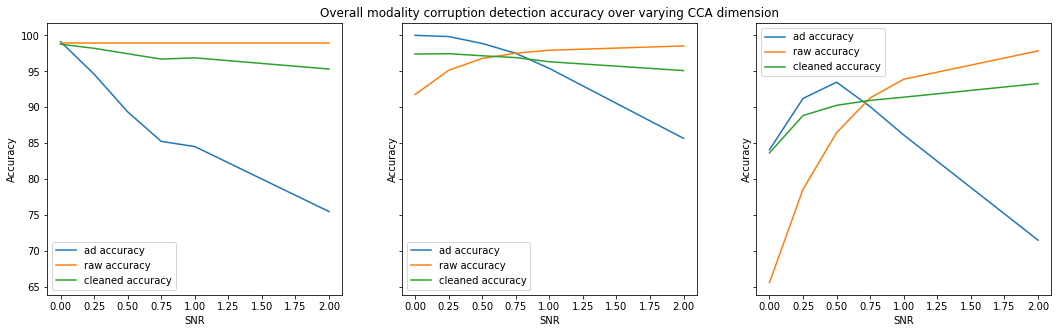

In [450]:
np.mean([acc[x][gmm][ax_idx] for gmm in range(5)])
fig, ax = plt.subplots(1,3, sharey=True, figsize=(18, 5))
for ax_idx in range(3):
    ax[ax_idx].plot([0.0,0.25,0.5,0.75,1.0,2.0], [100*np.mean([acc[x][gmm][ax_idx] for gmm in range(5)]) for x in range(6)])
    ax[ax_idx].plot([0.0,0.25,0.5,0.75,1.0,2.0], [100*np.mean([raw_acc[x][gmm][ax_idx] for gmm in range(5)]) for x in range(6)])
    ax[ax_idx].plot([0.0,0.25,0.5,0.75,1.0,2.0], [100*np.mean([clean_acc[x][gmm][ax_idx] for gmm in range(5)]) for x in range(6)])
    ax[ax_idx].legend(['ad accuracy', 'raw accuracy', 'cleaned accuracy'])
    ax[ax_idx].set_xlabel('SNR')
    ax[ax_idx].set_ylabel('Accuracy')
ax[1].set_title('Overall modality corruption detection accuracy over varying CCA dimension')
plt.show()

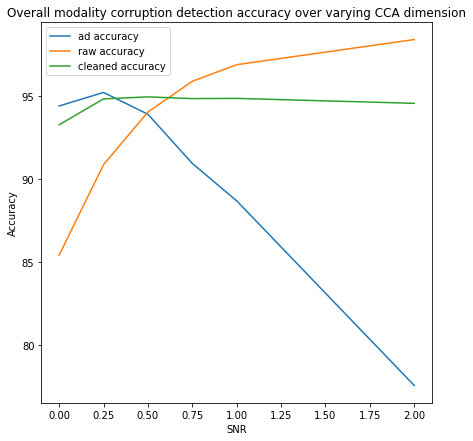

In [460]:
np.mean([acc[x][gmm][ax_idx] for gmm in range(5)])
fig, ax = plt.subplots(1,1, sharey=True, figsize=(7, 7))
ax.plot([0.0,0.25,0.5,0.75,1.0,2.0], np.mean(np.array([[100*np.mean([acc[x][gmm][corr] for gmm in range(5)]) for x in range(6)] for corr in range(3)]), axis=0))
ax.plot([0.0,0.25,0.5,0.75,1.0,2.0], np.mean(np.array([[100*np.mean([raw_acc[x][gmm][corr] for gmm in range(5)]) for x in range(6)] for corr in range(3)]), axis=0))
ax.plot([0.0,0.25,0.5,0.75,1.0,2.0], np.mean(np.array([[100*np.mean([clean_acc[x][gmm][corr] for gmm in range(5)]) for x in range(6)] for corr in range(3)]), axis=0))
ax.legend(['ad accuracy', 'raw accuracy', 'cleaned accuracy'])
ax.set_xlabel('SNR')
ax.set_ylabel('Accuracy')
ax.set_title('Overall modality corruption detection accuracy over varying CCA dimension')
plt.show()

In [483]:
acc = []
raw_acc = []
clean_acc = []
ad_clean_acc = []
for batch_size in [128]:
    for x, snr in enumerate([0.0,0.25,0.5,0.75,1.0,2.0]):
        acc.append([])
        raw_acc.append([])
        clean_acc.append([])
        ad_clean_acc.append([])
        for gmm_components in [5]:
            for cca_dim in [15]:
                for window_size in [30]:
                    for grace in [1]:
                        try:
                            with open('output/cnn_moddrop_{}_{}_{}_{}_{}_{}_gmm.pkl'.format(batch_size, snr, gmm_components, cca_dim, window_size, grace), 'rb') as f:
                                res = pickle.load(f)
                            acc[x].append([get_acc(res[ncorr]['ad'][0,:]) for ncorr in [0,1,2]])
                            raw_acc[x].append([res[ncorr]['raw'] for ncorr in [0,1,2]])
                            clean_acc[x].append([res[ncorr]['clean'] for ncorr in [0,1,2]])
                            ad_clean_acc[x].append([res[ncorr]['ad_clean'] for ncorr in [0,1,2]])
                        except FileNotFoundError:
                            print('cant find {}_{}_{}_{}_{}_{}_gaussian.pkl'.format(batch_size, snr, gmm_components, cca_dim, window_size, grace))
                            acc[x].append([0 for ncorr in [0,1,2]])
                            raw_acc[x].append([0 for ncorr in [0,1,2]])
                            clean_acc[x].append([0 for ncorr in [0,1,2]])
                            ad_clean_acc[x].append([0 for ncorr in [0,1,2]])

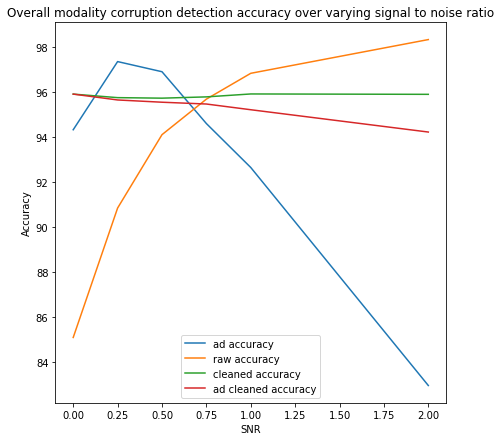

In [484]:
fig, ax = plt.subplots(1,1, sharey=True, figsize=(7, 7))
ax.plot([0.0,0.25,0.5,0.75,1.0,2.0], np.mean(np.array([[100*acc[x][0][corr] for x in range(6)] for corr in range(3)]), axis=0))
ax.plot([0.0,0.25,0.5,0.75,1.0,2.0], np.mean(np.array([[100*raw_acc[x][0][corr] for x in range(6)] for corr in range(3)]), axis=0))
ax.plot([0.0,0.25,0.5,0.75,1.0,2.0], np.mean(np.array([[100*clean_acc[x][0][corr] for x in range(6)] for corr in range(3)]), axis=0))
ax.plot([0.0,0.25,0.5,0.75,1.0,2.0], np.mean(np.array([[100*ad_clean_acc[x][0][corr] for x in range(6)] for corr in range(3)]), axis=0))
ax.legend(['ad accuracy', 'raw accuracy', 'cleaned accuracy', 'ad cleaned accuracy'])
ax.set_xlabel('SNR')
ax.set_ylabel('Accuracy')
ax.set_title('Overall modality corruption detection accuracy over varying signal to noise ratio')
plt.show()

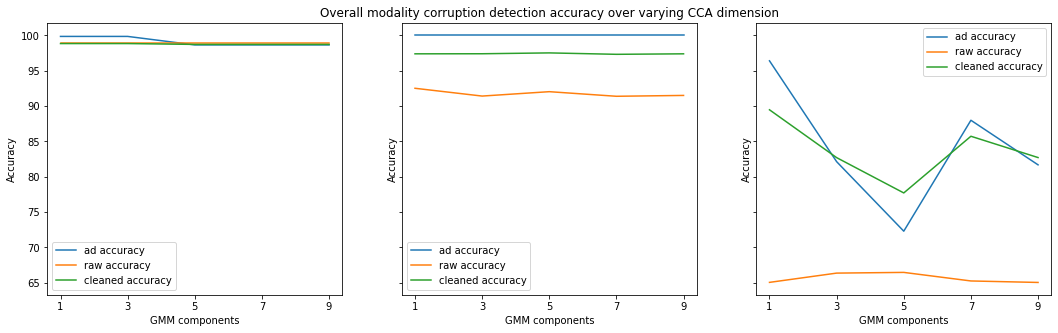

In [454]:
snr_idx = 0
fig, ax = plt.subplots(1,3, sharey=True, figsize=(18, 5))
for ax_idx in range(3):
    ax[ax_idx].plot([str(lab) for lab in [1,3,5,7,9]], [100*x[ax_idx] for x in acc[snr_idx]])
    ax[ax_idx].plot([str(lab) for lab in [1,3,5,7,9]], [100*x[ax_idx] for x in raw_acc[snr_idx]])
    ax[ax_idx].plot([str(lab) for lab in [1,3,5,7,9]], [100*x[ax_idx] for x in clean_acc[snr_idx]])
    ax[ax_idx].legend(['ad accuracy', 'raw accuracy', 'cleaned accuracy'])
    ax[ax_idx].set_xlabel('GMM components')
    ax[ax_idx].set_ylabel('Accuracy')
ax[1].set_title('Overall modality corruption detection accuracy over varying CCA dimension')
plt.show()

In [499]:
acc = []
raw_acc = []
clean_acc = []
ad_clean_acc = []
for batch_size in [128]:
    for x, snr in enumerate([0.0,0.25,0.5,0.75,1.0,2.0]):
        acc.append([])
        raw_acc.append([])
        clean_acc.append([])
        ad_clean_acc.append([])
        for gmm_components in [5]:
            for cca_dim in [15]:
                for window_size in [100]:
                    for grace in [0]:
                        try:
                            with open('output/cnn_moddrop_{}_{}_{}_{}_{}_{}_gmm.pkl'.format(batch_size, snr, gmm_components, cca_dim, window_size, grace), 'rb') as f:
                                res = pickle.load(f)
                            acc[x].append([get_acc(res[ncorr]['ad'][0,:]) for ncorr in [0,1,2]])
                            raw_acc[x].append([res[ncorr]['raw'] for ncorr in [0,1,2]])
                            clean_acc[x].append([res[ncorr]['clean'] for ncorr in [0,1,2]])
                            ad_clean_acc[x].append([res[ncorr]['ad_clean'] for ncorr in [0,1,2]])
                        except FileNotFoundError:
                            print('cant find {}_{}_{}_{}_{}_{}_gaussian.pkl'.format(batch_size, snr, gmm_components, cca_dim, window_size, grace))
                            acc[x].append([0 for ncorr in [0,1,2]])
                            raw_acc[x].append([0 for ncorr in [0,1,2]])
                            clean_acc[x].append([0 for ncorr in [0,1,2]])
                            ad_clean_acc[x].append([0 for ncorr in [0,1,2]])

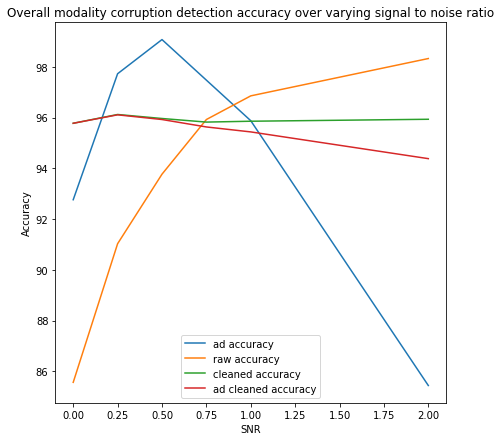

In [500]:
fig, ax = plt.subplots(1,1, sharey=True, figsize=(7, 7))
ax.plot([0.0,0.25,0.5,0.75,1.0,2.0], np.mean(np.array([[100*acc[x][0][corr] for x in range(6)] for corr in range(3)]), axis=0))
ax.plot([0.0,0.25,0.5,0.75,1.0,2.0], np.mean(np.array([[100*raw_acc[x][0][corr] for x in range(6)] for corr in range(3)]), axis=0))
ax.plot([0.0,0.25,0.5,0.75,1.0,2.0], np.mean(np.array([[100*clean_acc[x][0][corr] for x in range(6)] for corr in range(3)]), axis=0))
ax.plot([0.0,0.25,0.5,0.75,1.0,2.0], np.mean(np.array([[100*ad_clean_acc[x][0][corr] for x in range(6)] for corr in range(3)]), axis=0))
ax.legend(['ad accuracy', 'raw accuracy', 'cleaned accuracy', 'ad cleaned accuracy'])
ax.set_xlabel('SNR')
ax.set_ylabel('Accuracy')
ax.set_title('Overall modality corruption detection accuracy over varying signal to noise ratio')
plt.show()

In [497]:
acc = []
raw_acc = []
clean_acc = []
for batch_size in [128]:
    for x, snr in enumerate([0.0,0.25,0.5,0.75,1.0,2.0]):
        acc.append([])
        raw_acc.append([])
        clean_acc.append([])
        for gmm_components in [1,3,5,7,9]:
            for cca_dim in [15]:
                for window_size in [30]:
                    for grace in [0]:
                        try:
                            with open('output/cnn_moddrop_{}_{}_{}_{}_{}_{}.pkl'.format(batch_size, snr, gmm_components, cca_dim, window_size, grace), 'rb') as f:
                                res = pickle.load(f)
                            acc[x].append([get_acc(res[ncorr]['ad'][0,:]) for ncorr in [0,1,2]])
                            raw_acc[x].append([res[ncorr]['raw'] for ncorr in [0,1,2]])
                            clean_acc[x].append([res[ncorr]['clean'] for ncorr in [0,1,2]])
                        except FileNotFoundError:
                            print('cant find {}_{}_{}_{}_{}_{}.pkl'.format(batch_size, snr, gmm_components, cca_dim, window_size, grace))
                            acc[x].append([0 for ncorr in [0,1,2]])
                            raw_acc[x].append([0 for ncorr in [0,1,2]])
                            clean_acc[x].append([0 for ncorr in [0,1,2]])

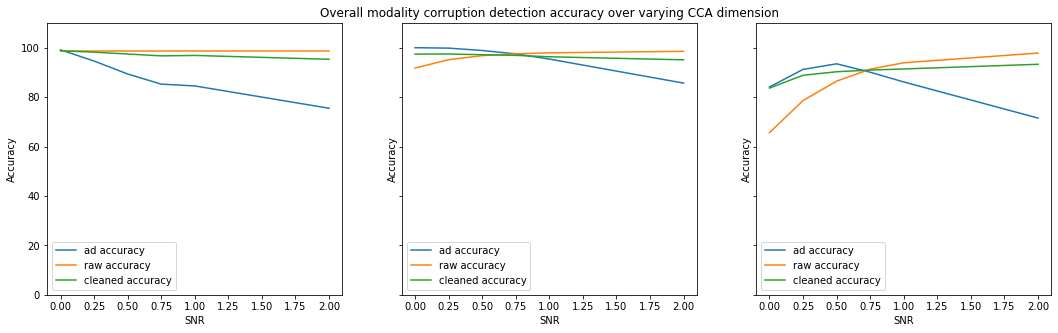

In [498]:
np.mean([acc[x][gmm][ax_idx] for gmm in range(5)])
fig, ax = plt.subplots(1,3, sharey=True, figsize=(18, 5))
for ax_idx in range(3):
    ax[ax_idx].plot([0.0,0.25,0.5,0.75,1.0,2.0], [100*np.mean([acc[x][gmm][ax_idx] for gmm in range(5)]) for x in range(6)])
    ax[ax_idx].plot([0.0,0.25,0.5,0.75,1.0,2.0], [100*np.mean([raw_acc[x][gmm][ax_idx] for gmm in range(5)]) for x in range(6)])
    ax[ax_idx].plot([0.0,0.25,0.5,0.75,1.0,2.0], [100*np.mean([clean_acc[x][gmm][ax_idx] for gmm in range(5)]) for x in range(6)])
    ax[ax_idx].legend(['ad accuracy', 'raw accuracy', 'cleaned accuracy'])
    ax[ax_idx].set_xlabel('SNR')
    ax[ax_idx].set_ylabel('Accuracy')
plt.ylim(0,110)
ax[1].set_title('Overall modality corruption detection accuracy over varying CCA dimension')
plt.show()

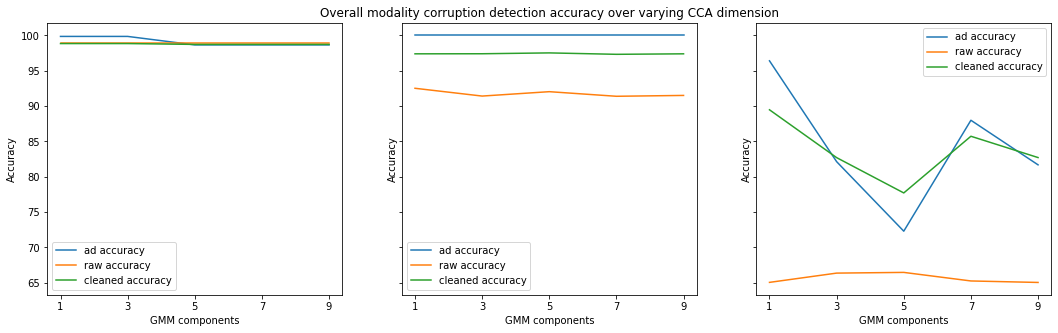

In [442]:
snr_idx = 5
fig, ax = plt.subplots(1,3, sharey=True, figsize=(18, 5))
for ax_idx in range(3):
    ax[ax_idx].plot([str(lab) for lab in [1,3,5,7,9]], [100*x[ax_idx] for x in acc[snr_idx]])
    ax[ax_idx].plot([str(lab) for lab in [1,3,5,7,9]], [100*x[ax_idx] for x in raw_acc[snr_idx]])
    ax[ax_idx].plot([str(lab) for lab in [1,3,5,7,9]], [100*x[ax_idx] for x in clean_acc[snr_idx]])
    ax[ax_idx].legend(['ad accuracy', 'raw accuracy', 'cleaned accuracy'])
    ax[ax_idx].set_xlabel('GMM components')
    ax[ax_idx].set_ylabel('Accuracy')
ax[1].set_title('Overall modality corruption detection accuracy over varying CCA dimension')
plt.show()